In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import filtfilt, butter, argrelextrema
import numpy as np
%matplotlib inline 

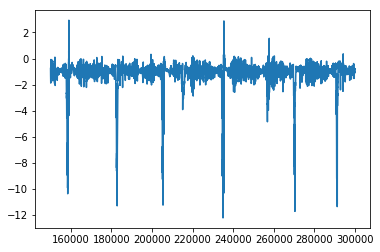

In [3]:
data = pd.read_csv("14 03 20 Roma ice_pSensor_2020-03-14T11.38.29.013_FC7005861603_Accelerometer.csv")
data.columns = ['ms','t','s','x','y','z']
data = data.drop(['ms','t'], axis=1)
strt_dt = 6518
data['s']= (data['s']*1000-strt_dt).apply(int)
data = data.groupby('s').min()
click_t = 7700
data = data.loc[click_t:]
data['a'] = (data['x']**2 + data['y']**2 + data['z']**2)**0.5
plt.plot(data['x'].loc[150000:300000])

In [9]:
max(data['z'])

4.864

In [146]:
# Достаем данные из БД
from mysql import connector 
m_id = 3
conn = connector.connect(host='127.0.0.1', user='root', password='T0_Gather', database='NAVKA2')
cursor = conn.cursor()
for i in data.loc[150000:300000].index:
    d = data.loc[i]
    a = f"(3, {int(i)}, {d[0]}, {d[1]}, {d[2]})"
    cursor.execute(f"INSERT INTO vAcc (sid,tick,x,y,z) VALUES {a}")
conn.commit()

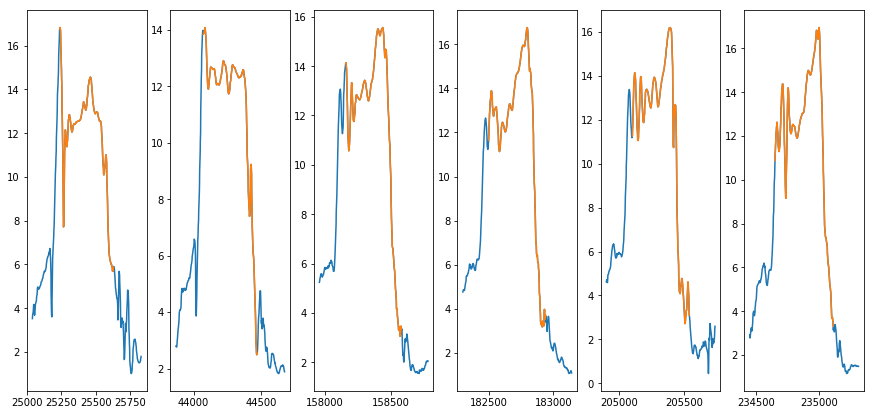

In [129]:
jmps_real = [(25240,25630),
             (44070,44470),
             #(73635,74050),
             #(85700,86187),
             #(95568,96068),
             #(146170,146470), #С разворота (по факту 2 ипульса) 
             (158160,158580),
             (182500,182940),
             (205100,205540),
             (234650,235110)
            ]

j=1
plt.figure(figsize=(15,7))
for i in jmps_real:
    a,b = i
    plt.subplot(1,len(jmps_real),j)
    plt.plot(data['a'].loc[a-200:b+200])
    plt.plot(data['a'].loc[a:b])
    j+=1

In [130]:
# Вспомогательный метод вместо MinMaxScaler
def minmax(a):
    result = []
    mn, mx = min(a), max(a)
    if mn != mx:
        for i in a:
            result.append((i - mn) / (mx - mn))
    else:
        result =a
    return np.array(result)

# Вспомогательный метод вместо фильтрация +  MinMaxScaler
fminmax = lambda d, f, s: minmax(abs(filtfilt(*butter(3, f, s), d, axis=0)))

In [131]:
def get_csc(a, max_gap=150, min_acc=4.5, min_csc_size=300):
    ind = a[a['a']>min_acc].index.values

    # объединение всплесков с каскадами
    res = [[ind[0]]]
    for i in range(len(ind)-1):
        d = ind[i+1]-ind[i]
        if d>max_gap:
            res[-1].append(ind[i])
            res.append([ind[i+1]])
    res[-1].append(ind[-1])
    # удаление каскадов в которые не поместился бы нормальный прыжок
    result = []
    for c in res:
        a,b = c
        if b-a>min_csc_size:
            # Корректировка, чтобы захватить минимумы после каскада
            result.append((a, b+0))
    return result

In [150]:
def get_jmp(a,f=0.015):
    t = a.index.values
    ti = list(range(t[0],t[-1],1))
    a = pd.merge(pd.DataFrame(index=ti), a,left_index=True, right_index=True, how='outer')
    a = a.interpolate()
    
    g = np.gradient(a.to_numpy().T[0],edge_order=2)
    dat = fminmax(g, f, 'lp')
    plt.plot(a.index.values, dat*10)
    
    ex = list(argrelextrema(dat, np.greater, order = 100)[0])
    a = a.iloc[ex]
    plt.plot(a, '--', marker='x')
    return (list(a.index))


In [147]:
csc = get_csc(data)
print(csc)
plt.figure(figsize=(16,5))
j=1
for i in range(len(jmps_real)):
    plt.subplot(1,len(jmps_real),j)
    a,b = csc[i]
    x = get_jmp(data['a'].loc[a:b])
    a,b = jmps_real[i]
    print(x[-1]-b, x[0]-a, (b-a)-(x[-1]-x[0]))
    plt.plot(data['a'].loc[a:b])
    j+=1


[(25072, 25737), (43910, 44494), (157949, 158541), (182297, 182894), (204899, 205530), (234502, 235092), (269925, 270560), (290775, 291407)]


[25203, 25584]
[44045, 44421]
[158094, 158515]
[182451, 182873]
[205051, 205439]
[234642, 235040]
[270071, 270487]
[290917, 291315]


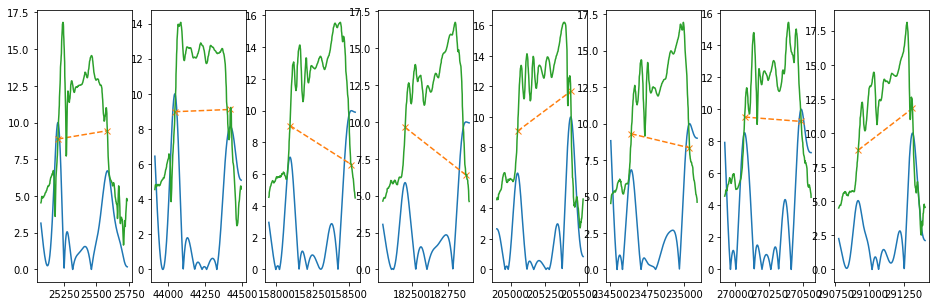

In [151]:
csc = get_csc(data)
plt.figure(figsize=(16,5))
j=1
for i in range(len(csc)):
    plt.subplot(1,len(csc),j)
    a,b = csc[i]
    x = get_jmp(data['a'].loc[a:b])
    print(x)
    plt.plot(data['a'].loc[a:b])
    j+=1
